# Visualizing the results

In this section, we will visualize the results of the experiment in which we have added an 'ethical coefficient'.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import cartogram
import netCDF4

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.animation import FuncAnimation


In [7]:
ds = xr.open_dataset("../../../results/batch/run_ds_19_07_3.nc")

In [5]:
ds.close()

In [6]:
ds_path = '../../../results/batch/run_ds_19_07.nc'
ds = xr.open_dataset(ds_path)

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [8]:
variables = ['define_tot_eq_define_total_impact',
       'dice_tot_eq_dice_total_impact',   
       'witness_tot_eq_witness_total_impact']

#        'fund_tot_eq_monetary_impact', removed FUND because otherwise we couldn't read the other models

df = ds[variables].to_dataframe().reset_index()
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

df

,Run,time,region,define_tot_eq_define_total_impact,dice_tot_eq_dice_total_impact,witness_tot_eq_witness_total_impact
0,0,2005.0,AUSTRIA,0.000000,0.000000,0.000000
1,0,2005.0,BELGIUM,3013.924745,3640.826347,6151.837126
2,0,2005.0,BULGARIA,9.850048,11.898875,20.105310
3,0,2005.0,CROATIA,30.546498,36.900223,62.349626
4,0,2005.0,CYPRUS,50.456935,60.952065,102.989580
...,...,...,...,...,...,...
2095,9,2010.0,INDIA,149407.098797,177695.334845,300403.922335
2096,9,2010.0,LATAM,30223.038877,35945.367097,60767.657604
2097,9,2010.0,RUSSIA,11800.104409,14034.296369,23725.764551
2098,9,2010.0,USMCA,29874.062568,35530.316792,60065.991802


In [9]:
27240/(15*35)

51.885714285714286

Removing weird outliers : 

In [10]:
df = df[~df['time'].isin([2015, 2043,  2048])]

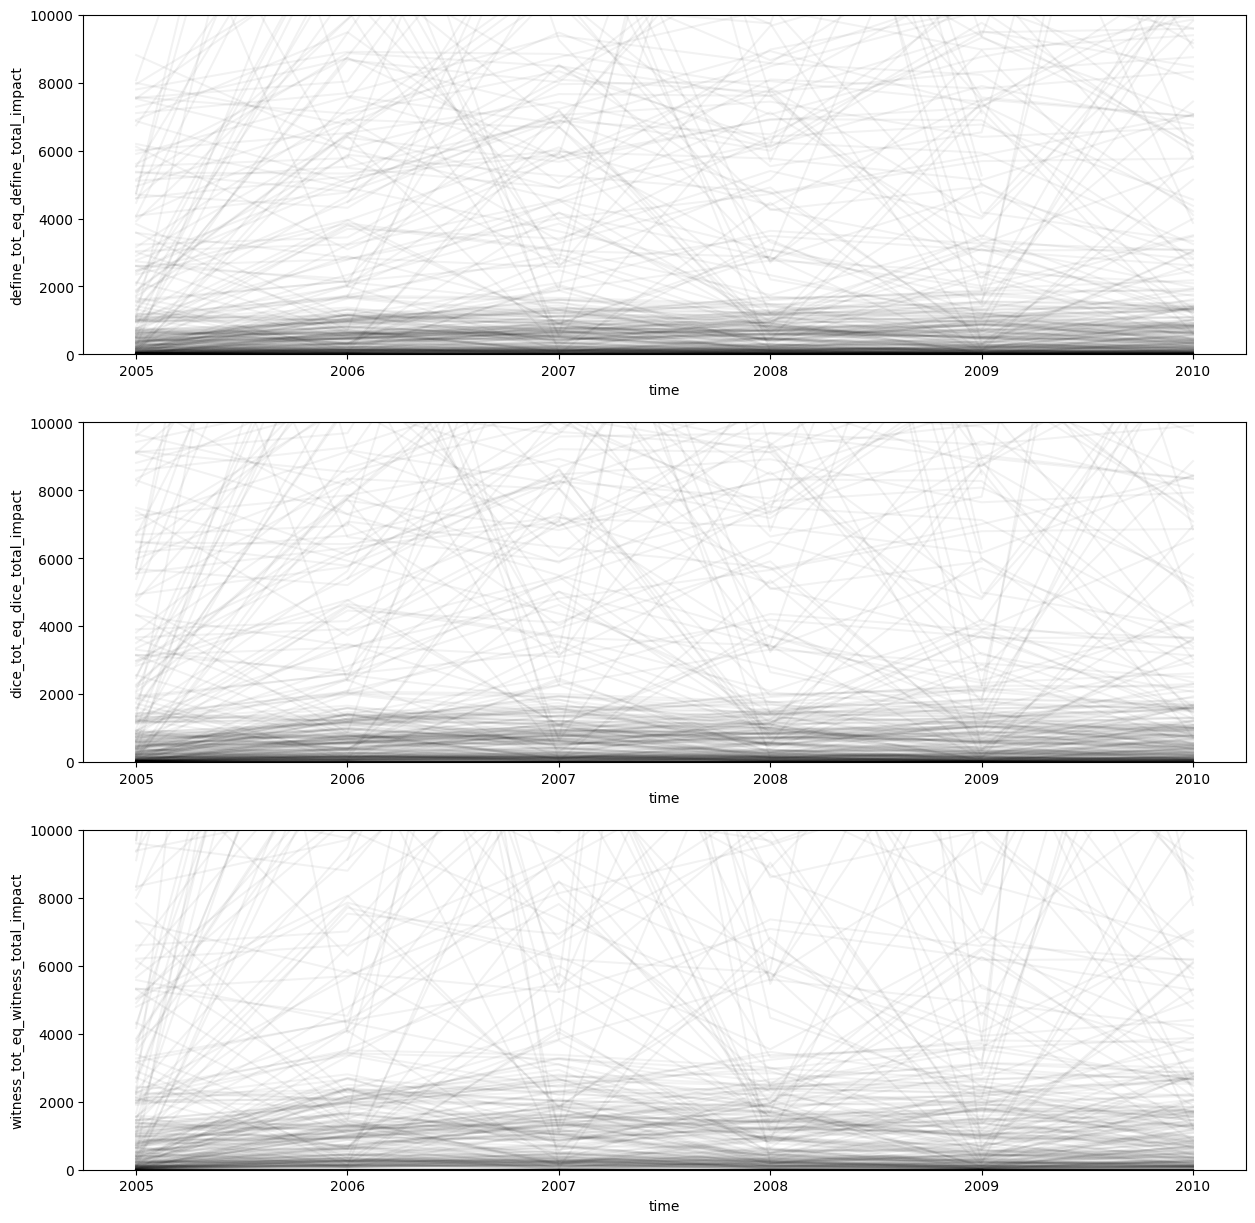

In [14]:
variables = ['define_tot_eq_define_total_impact',
       'dice_tot_eq_dice_total_impact',   
       'witness_tot_eq_witness_total_impact']

fig, ax = plt.subplots(len(variables), 1, figsize = (5*len(variables), 15))

mean_multiplier = 1.5
df_mean = df[df['dice_tot_eq_dice_total_impact']<mean_multiplier*df['dice_tot_eq_dice_total_impact'].mean()]

for i, v in enumerate(variables): 
    for run in df['Run'].unique():
        for region in df['region'].unique():

            data = df_mean[(df_mean['Run']==run)&(df_mean['region']==region)]
            #print(data.shape)
            sns.lineplot(data=data, x='time', y=v, color='black', alpha=0.05, ax=ax[i])

            ax[i].set_ylim(0, 10000)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

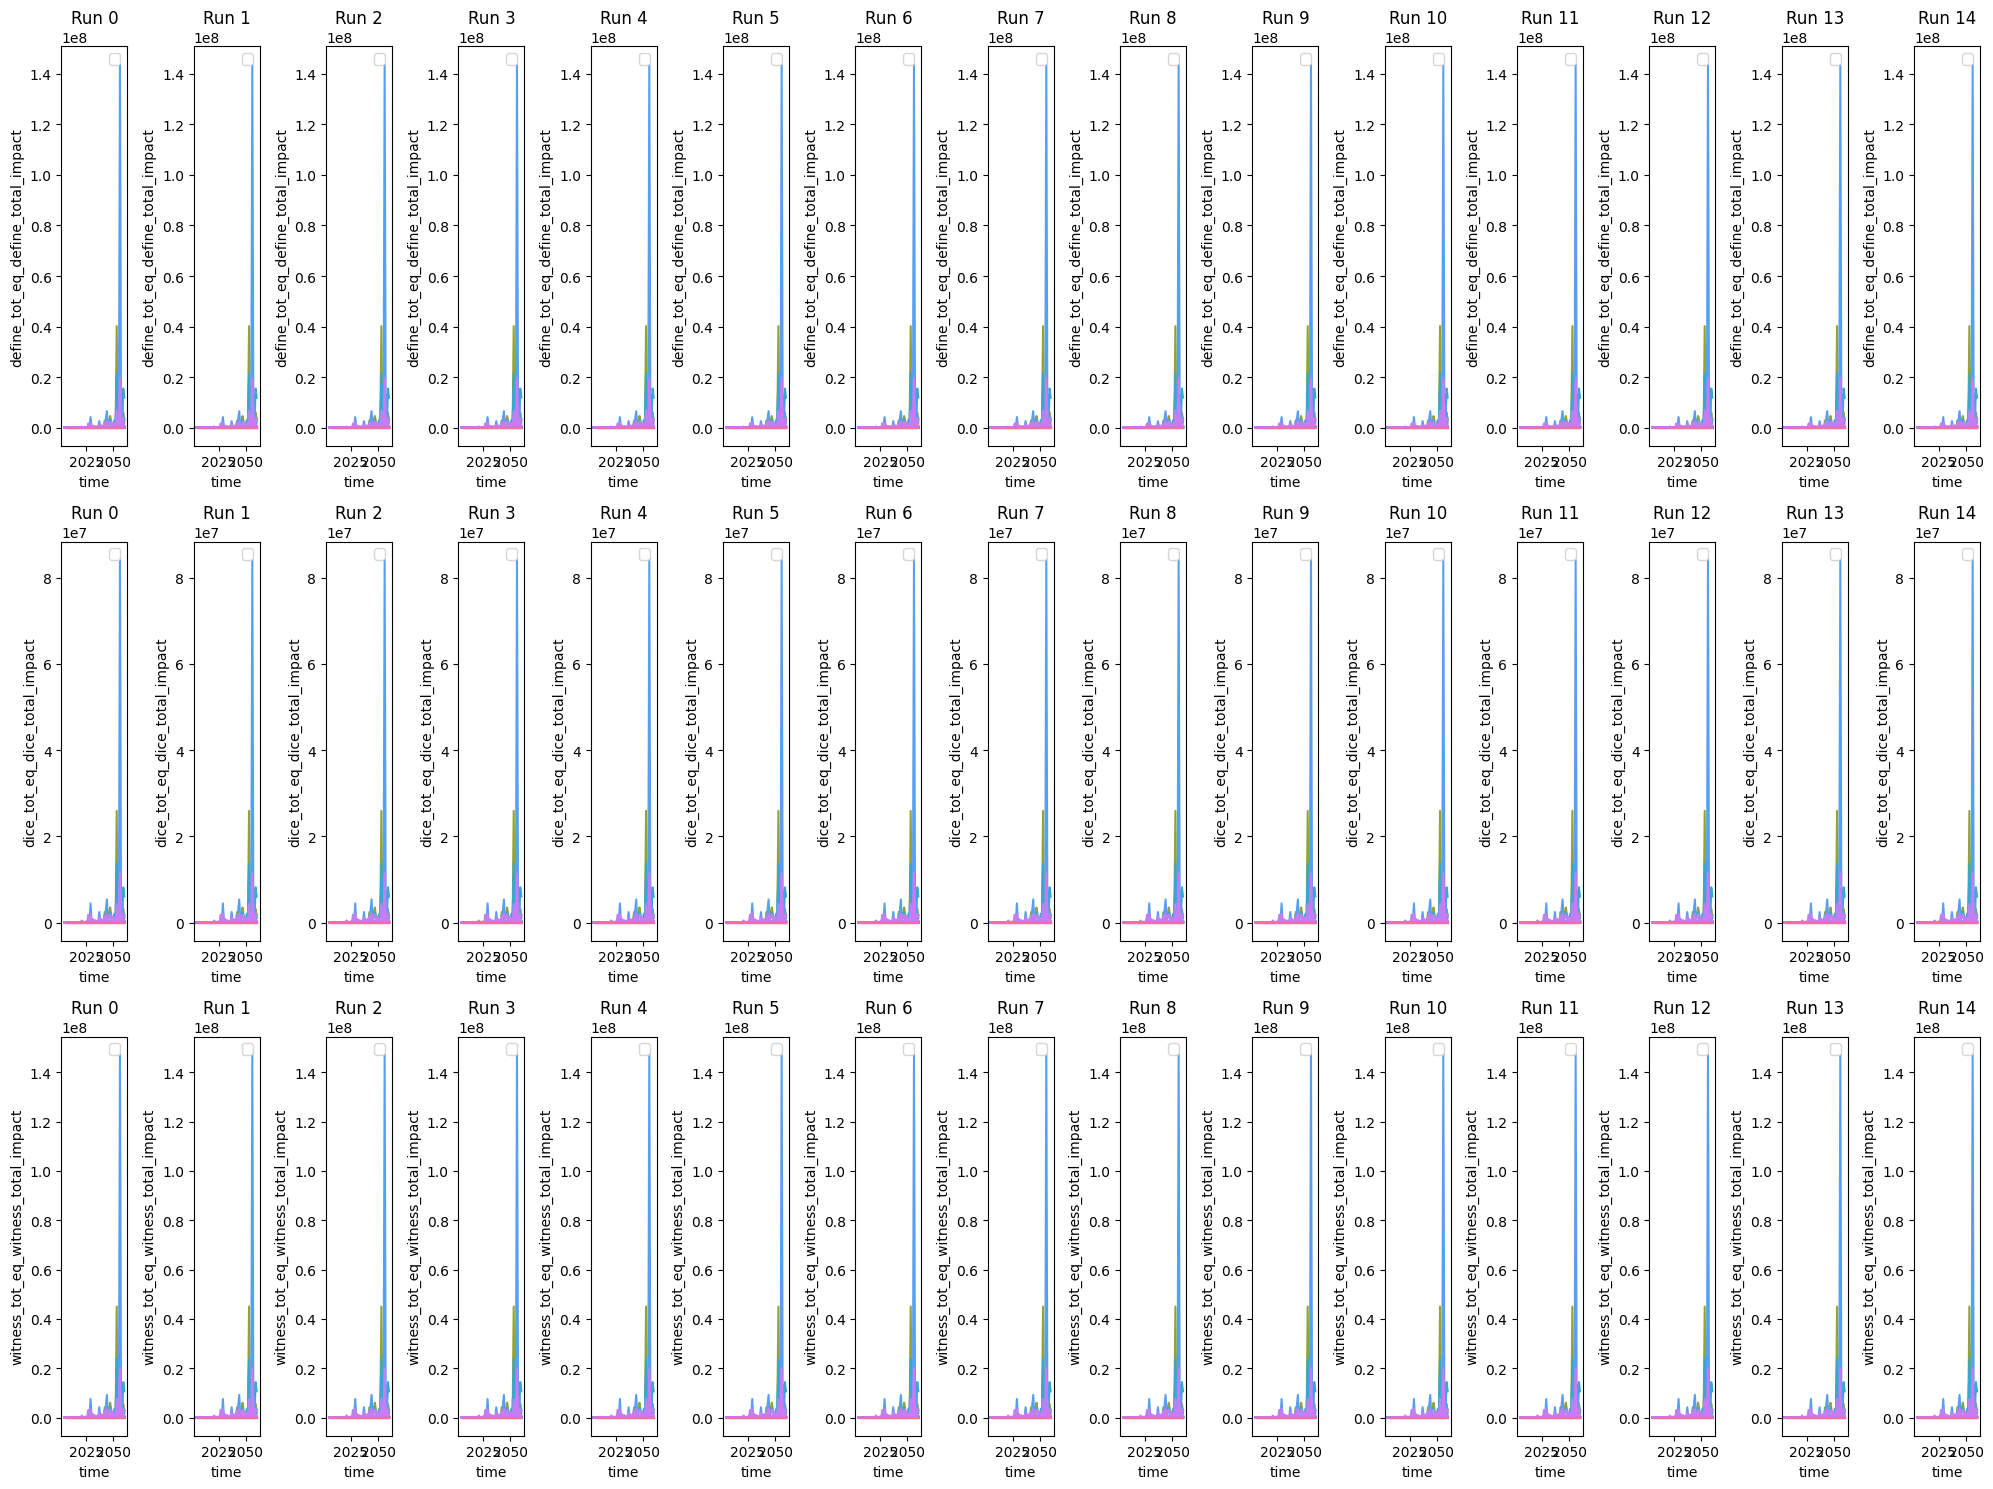

In [6]:
run = df['Run'].unique()

fig, ax = plt.subplots(len(variables), len(run), figsize=(20, 15))

for j, r in enumerate(run):
    for i, v in enumerate(variables):
        sns.lineplot(data=df[df['Run'] == r], x='time', hue='REGIONS 35 I', y=v, ax=ax[i, j], legend=False)
        ax[i, j].set_title(f'Run {r}')
        ax[i, j].set_ylabel(v)
        ax[i, j].legend()

plt.tight_layout()  
plt.show()

## Map showing model as a variable

Let's map ! 

ValueError: aspect must be finite and positive 

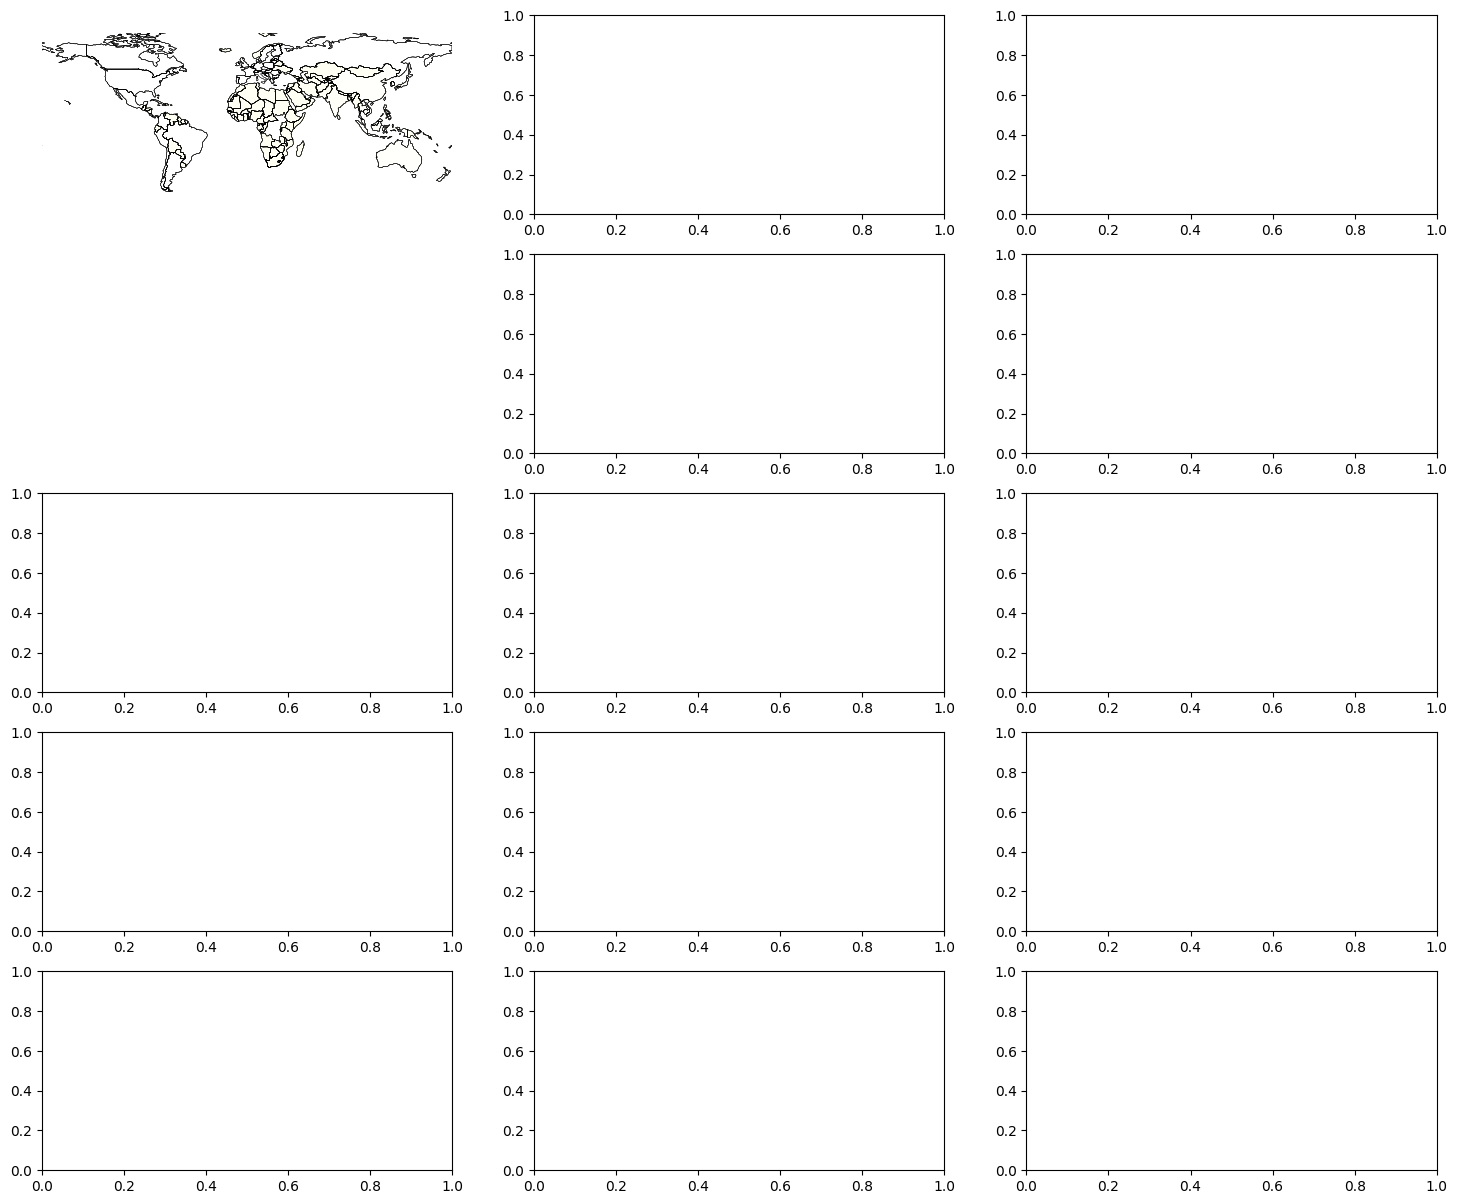

In [17]:
decades = np.arange(2010, 2051, 10)

fig, ax = plt.subplots(len(decades), len(variables), figsize=(18, 15))

map = gpd.read_file(r'../../../docs/source/3_modelling\geography\output_countries\countries.shp')

vmin = df[variables].values.min()
vmax = df[variables].values.max()


for j, r in enumerate(variables):
    for i, d in enumerate(decades):
        map_variable = map.merge(df[df['time'] == d], left_on='region', right_on='region')

        ax[i, j].set_axis_off()
        ax[i, j].set_xlim(-180, 180)
        ax[i, j].set_ylim(-60, 80)

        map_variable.boundary.plot(ax=ax[i, j], linewidth=0.2, color='black', alpha=0.5)
        map_variable.plot(column=r, ax= ax[i,j], cmap='hot_r', vmin=vmin, vmax=vmax)

        if j == 0:
            ax[i, j].set_ylabel(f'{d}', fontsize=12)
        
# Créer un objet Normalize pour normaliser les valeurs dans [vmin, vmax] à [0, 1]
norm = Normalize(vmin=vmin, vmax=vmax)

# Créer une ScalarMappable pour mapper les valeurs normalisées à une colormap
sm = ScalarMappable(cmap='hot_r', norm=norm)
sm.set_array([])  # Mettre un tableau vide, les données ne sont pas encore nécessaires

# Ajout d'une colorbar commune pour toutes les sous-graphiques
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.6)
cbar.set_label('Damage level')  # Définir le label de la colorbar

#plt.tight_layout()

plt.savefig('../../../figures/output.png')


## Anamorphic map (cartogram)

In [8]:
map['WILIAM cod'].unique()

array(['LROW', 'USMCA', 'EASOC', 'LATAM', 'Russia', 'EU27', 'India',
       'China', 'UK'], dtype=object)

In [9]:
map_variable.sort_values(by='define_tot_eq_define_total_impact', ascending=False)

,pop_est,continent,name,iso_a3,gdp_md_est,WILIAM reg,WILIAM cod,REGIONS 35,FUND code,FUND regio,Country,ISO,geometry,Run,time,REGIONS 35 I,define_tot_eq_define_total_impact,dice_tot_eq_dice_total_impact,witness_tot_eq_witness_total_impact
0,889953.0,Oceania,Fiji,FJI,5496,Rest of the world,LROW,LROW,SIS,Small Island States,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0,2050.0,LROW,1.353249e+06,954982.164825,1.650900e+06
1255,9770529.0,Asia,United Arab Emirates,ARE,421142,Rest of the world,LROW,LROW,MDE,Middle East,United Arab Emirates,ARE,"POLYGON ((51.57952 24.24550, 51.75744 24.29407...",10,2050.0,LROW,1.353249e+06,954982.164825,1.650900e+06
1267,2832067.0,Asia,Qatar,QAT,175837,Rest of the world,LROW,LROW,MDE,Middle East,Qatar,QAT,"POLYGON ((50.81011 24.75474, 50.74391 25.48242...",7,2050.0,LROW,1.353249e+06,954982.164825,1.650900e+06
1266,2832067.0,Asia,Qatar,QAT,175837,Rest of the world,LROW,LROW,MDE,Middle East,Qatar,QAT,"POLYGON ((50.81011 24.75474, 50.74391 25.48242...",6,2050.0,LROW,1.353249e+06,954982.164825,1.650900e+06
1265,2832067.0,Asia,Qatar,QAT,175837,Rest of the world,LROW,LROW,MDE,Middle East,Qatar,QAT,"POLYGON ((50.81011 24.75474, 50.74391 25.48242...",5,2050.0,LROW,1.353249e+06,954982.164825,1.650900e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2279,1198575.0,Asia,Cyprus,CYP,24948,European Union,EU27,CYPRUS,WEU,Western Europe,Cyprus,CYP,"POLYGON ((32.73178 35.14003, 32.91957 35.08783...",14,2050.0,CYPRUS,5.992813e+02,422.910265,7.310948e+02
2266,1198575.0,Asia,Cyprus,CYP,24948,European Union,EU27,CYPRUS,WEU,Western Europe,Cyprus,CYP,"POLYGON ((32.73178 35.14003, 32.91957 35.08783...",1,2050.0,CYPRUS,5.992813e+02,422.910265,7.310948e+02
2265,1198575.0,Asia,Cyprus,CYP,24948,European Union,EU27,CYPRUS,WEU,Western Europe,Cyprus,CYP,"POLYGON ((32.73178 35.14003, 32.91957 35.08783...",0,2050.0,CYPRUS,5.992813e+02,422.910265,7.310948e+02
2268,1198575.0,Asia,Cyprus,CYP,24948,European Union,EU27,CYPRUS,WEU,Western Europe,Cyprus,CYP,"POLYGON ((32.73178 35.14003, 32.91957 35.08783...",3,2050.0,CYPRUS,5.992813e+02,422.910265,7.310948e+02


In [10]:
map = gpd.read_file(r'../../../WILIAM\geography\output_countries\countries.shp')    

map_variable = map.merge(df[df['time'] == 2040], left_on='REGIONS 35', right_on='REGIONS 35 I')

# Sum map variables by WILIAM regions
map_variable = map_variable.dissolve(by='WILIAM cod', aggfunc={'define_tot_eq_define_total_impact': 'sum'}).reset_index()


c = cartogram.Cartogram(map_variable, 'define_tot_eq_define_total_impact')

c:\Users\gabriel.genelot\AppData\Local\Programs\Python\Python312\Lib\site-packages\cartogram\cartogram.py:268: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return self.geometry.area.sum()
c:\Users\gabriel.genelot\AppData\Local\Programs\Python\Python312\Lib\site-packages\cartogram\cartogram.py:268: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return self.geometry.area.sum()
c:\Users\gabriel.genelot\AppData\Local\Programs\Python\Python312\Lib\site-packages\cartogram\cartogram.py:268: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return self.geometry.area.sum()
c:\Users\gabriel.genel

In [11]:
c.explore()

<GeoAxes: >

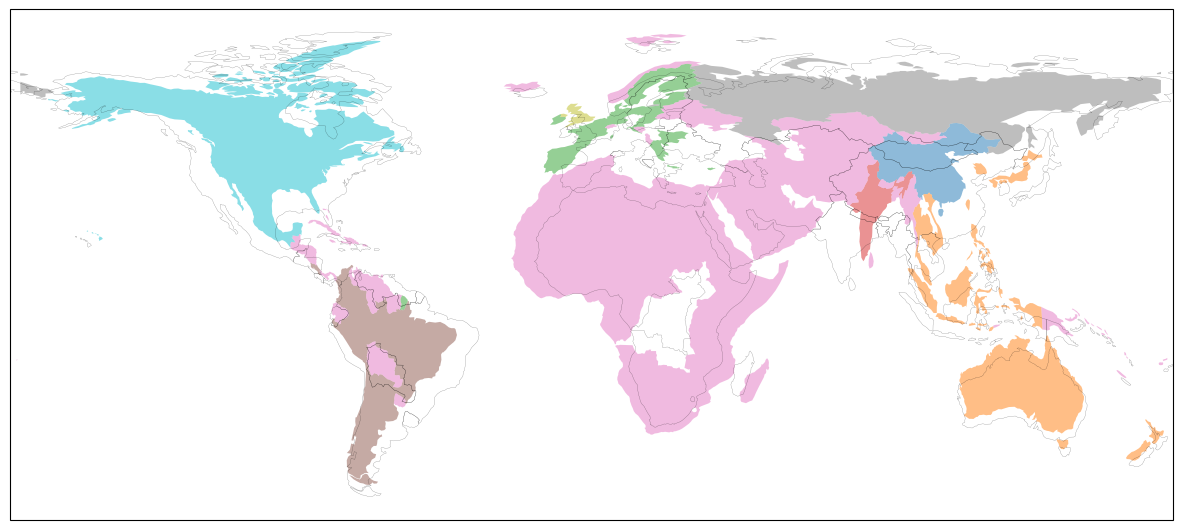

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

map_variable.boundary.plot(ax=ax, linewidth=0.2, color='black', alpha=0.5)


c.plot('WILIAM cod',  ax=ax, alpha=0.5)